In [24]:
import os
import time
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset (Ants and Bees)

You can download the dataset from here: https://www.kaggle.com/datasets/thedatasith/hymenoptera

In [26]:
data_dir = '/content/drive/MyDrive/ants_and_bees/lab4/hymenoptera'

### Data augementation

In [27]:
train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tranformer = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Dataset and Dataloaders

In [28]:
train_dataset = datasets.ImageFolder(
    os.path.join(data_dir, 'train'),
    train_transformer
)
test_dataset = datasets.ImageFolder(
    os.path.join(data_dir, 'val'),
    val_tranformer
)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, shuffle=True, num_workers=2, drop_last=True
)

In [29]:
dataset_sizes = len(train_dataset), len(test_dataset)
print(dataset_sizes)
class_names = train_dataset.classes

use_gpu = torch.cuda.is_available()
use_gpu

(244, 153)


True

## Image Vis

In [30]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

## Size of Input

In [31]:
inputs, classes = next(iter(trainloader))
out = torchvision.utils.make_grid(inputs)
out.size()

torch.Size([3, 248, 986])

## Helper Functions

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    losses = {'train': [], "val": []}
    pbar = trange(num_epochs, desc="Epoch:")
    for _ in pbar:

        #train
        model.train(True)
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, leave=False, desc='train iter:'):
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / dataset_sizes[0]
        losses['train'].append(epoch_loss)
        pbar.set_description(
            'Train Loss: {:.4f}'.format(epoch_loss)
        )
        scheduler.step()
        #validate
        running_loss = 0.0
        running_corrects = 0
        model.eval()
        for inputs, labels in tqdm(testloader, leave=False, desc=f"val iter:"):
            if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
            with torch.no_grad():
                outputs = model(inputs)
            preds = torch.argmax(outputs, -1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += int(torch.sum(preds == labels.data))

        epoch_loss = running_loss / dataset_sizes[1]
        epoch_acc = running_corrects / dataset_sizes[1]
        losses['val'].append(epoch_loss)
        pbar.set_description(
            'Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch_loss, epoch_acc)
        )
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format( time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, losses

In [33]:
def visualize_model(model, num_images=6) -> None:
    images_so_far = 0
    fig = plt.figure(figsize=(5, 2))

    model.eval()
    for i, data in enumerate(testloader):
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')

            ax.set_title(f'Predicted: {class_names[preds[j]]}')
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                plt.show()
                return
    plt.show()

In [34]:
def evaluate(model: nn.Module) -> tuple[float, np.ndarray, np.ndarray]:
    model.eval()

    y_hat = []
    y = []

    runninig_correct = 0
    for data in testloader:
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        output = model(inputs)
        _, predicted = torch.max(output, 1)
        y_hat.append(predicted.cpu().numpy())
        y.append(labels.cpu().numpy())

        runninig_correct += int(torch.sum(predicted == labels))

    return runninig_correct / dataset_sizes[1], np.concatenate(y_hat), np.concatenate(y)

## Model Alexnet

In [35]:
alexnet = models.alexnet(weights='IMAGENET1K_V1')

In [36]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Freeze model weights

In [37]:
for param in alexnet.features.parameters():
    param.requires_grad = False

Linear layer for binary classification

In [38]:
num_features = 4096
# alexnet.classifier = nn.Linear(num_features, 2)
alexnet.classifier[6] = nn.Linear(num_features, 2)

if use_gpu:
    alexnet = alexnet.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(alexnet.parameters(), lr=1e-4)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [39]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Model VggNet

In [40]:
vggnet = models.vgg16(weights='IMAGENET1K_V1')

In [41]:
vggnet

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Freeze model weights

In [42]:
for param in vggnet.features.parameters():
    param.requires_grad = False

In [43]:
vggnet.classifier[6] = nn.Linear(num_features, 2)

if use_gpu:
    vggnet = vggnet.cuda()

In [44]:
vggnet

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Train the models

In [ ]:
alexnet_retrained, alexnet_losses = train_model(alexnet, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=5)

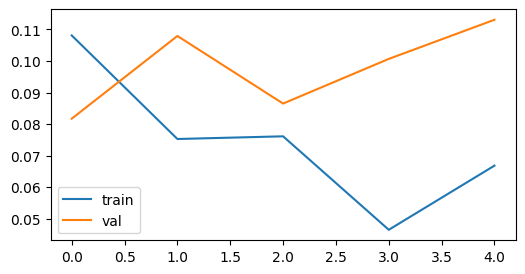

In [46]:
plt.figure(figsize=(6, 3))
plt.plot(alexnet_losses['train'], label="train")
plt.plot(alexnet_losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
vggnet_retrained, vggnet_losses = train_model(vggnet, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=5)

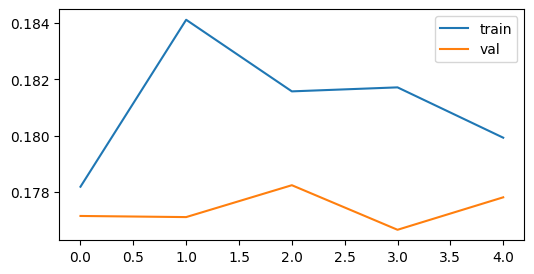

In [48]:
plt.figure(figsize=(6, 3))
plt.plot(vggnet_losses['train'], label="train")
plt.plot(vggnet_losses['val'], label="val")
plt.legend()
plt.show()

## Evaluate the models

### AlexNet

In [49]:
torch.save(alexnet_retrained.state_dict(), 'AlexNet_fine_tune.pth')
alexnet_retrained.load_state_dict(torch.load('AlexNet_fine_tune.pth', weights_only=True))
acc, y_hat, y = evaluate(alexnet_retrained)
print("Accuracy: {0:.4f}".format(acc))

Accuracy: 0.8693


In [50]:
cm = confusion_matrix(y_true=y, y_pred=y_hat)
report = classification_report(y_true=y, y_pred=y_hat)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        70
           1       0.90      0.87      0.88        82

    accuracy                           0.88       152
   macro avg       0.87      0.88      0.87       152
weighted avg       0.88      0.88      0.88       152



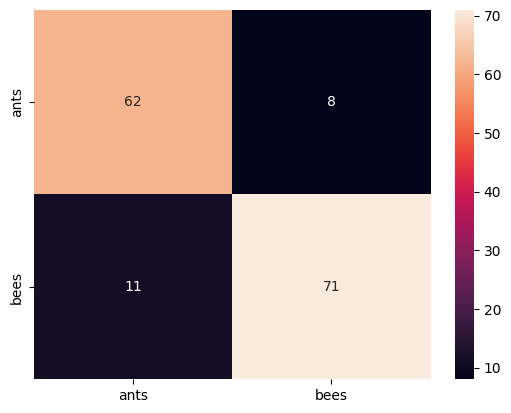

In [51]:
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
print(report)
plt.show()

### VggNet

In [52]:
torch.save(vggnet_retrained.state_dict(), 'VggNet_fine_tune.pth')
vggnet_retrained.load_state_dict(torch.load('VggNet_fine_tune.pth', weights_only=True))
acc, y_hat, y = evaluate(vggnet_retrained)
print("Accuracy: {0:.4f}".format(acc))

Accuracy: 0.5098


In [53]:
cm = confusion_matrix(y_true=y, y_pred=y_hat)
report = classification_report(y_true=y, y_pred=y_hat)

              precision    recall  f1-score   support

           0       0.48      0.80      0.60        70
           1       0.61      0.27      0.37        82

    accuracy                           0.51       152
   macro avg       0.55      0.53      0.49       152
weighted avg       0.55      0.51      0.48       152



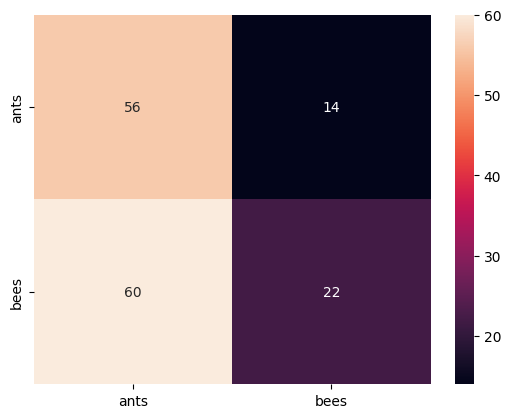

In [54]:
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
print(report)
plt.show()

## Test

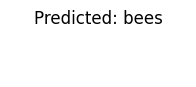

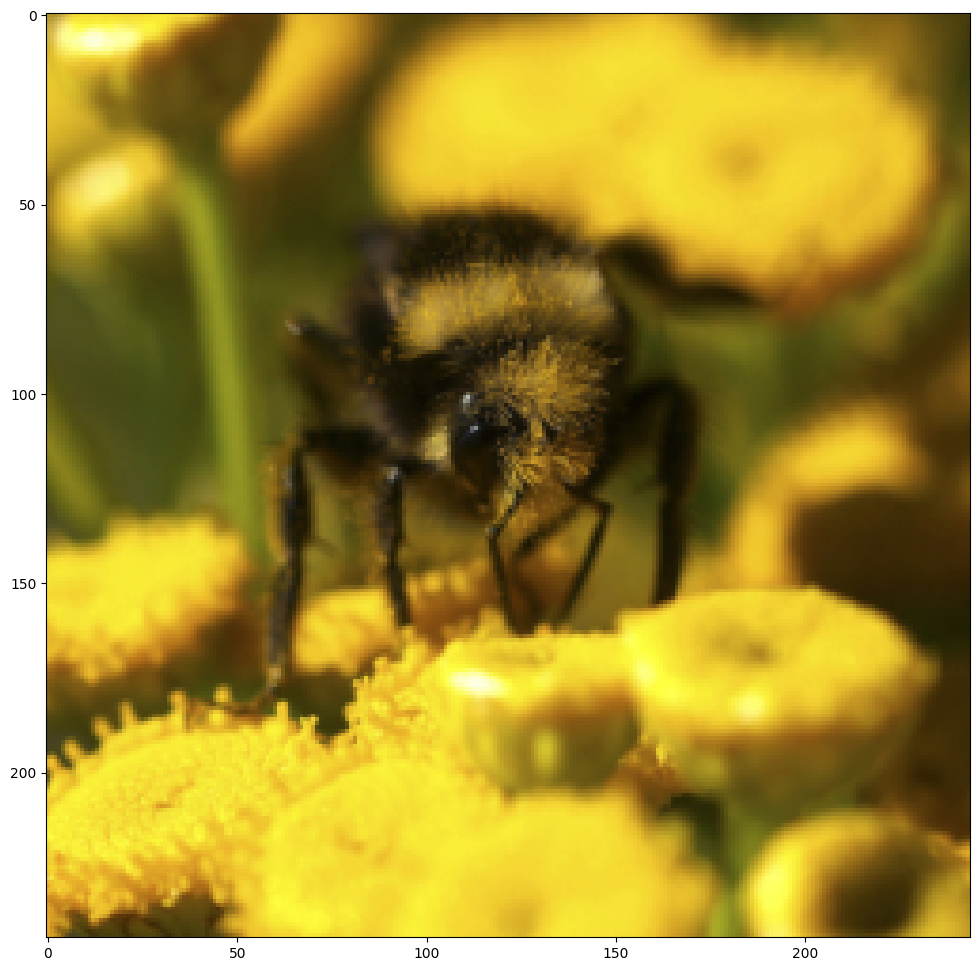

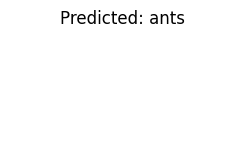

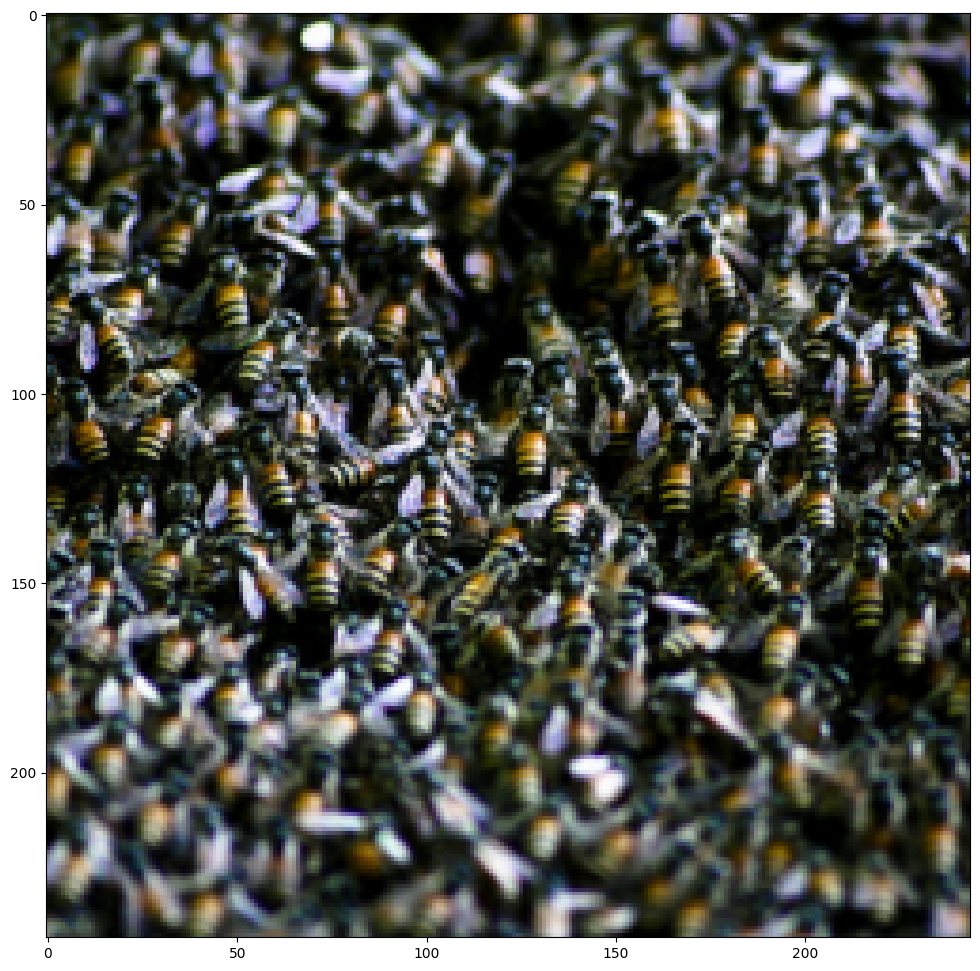

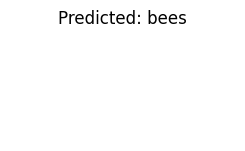

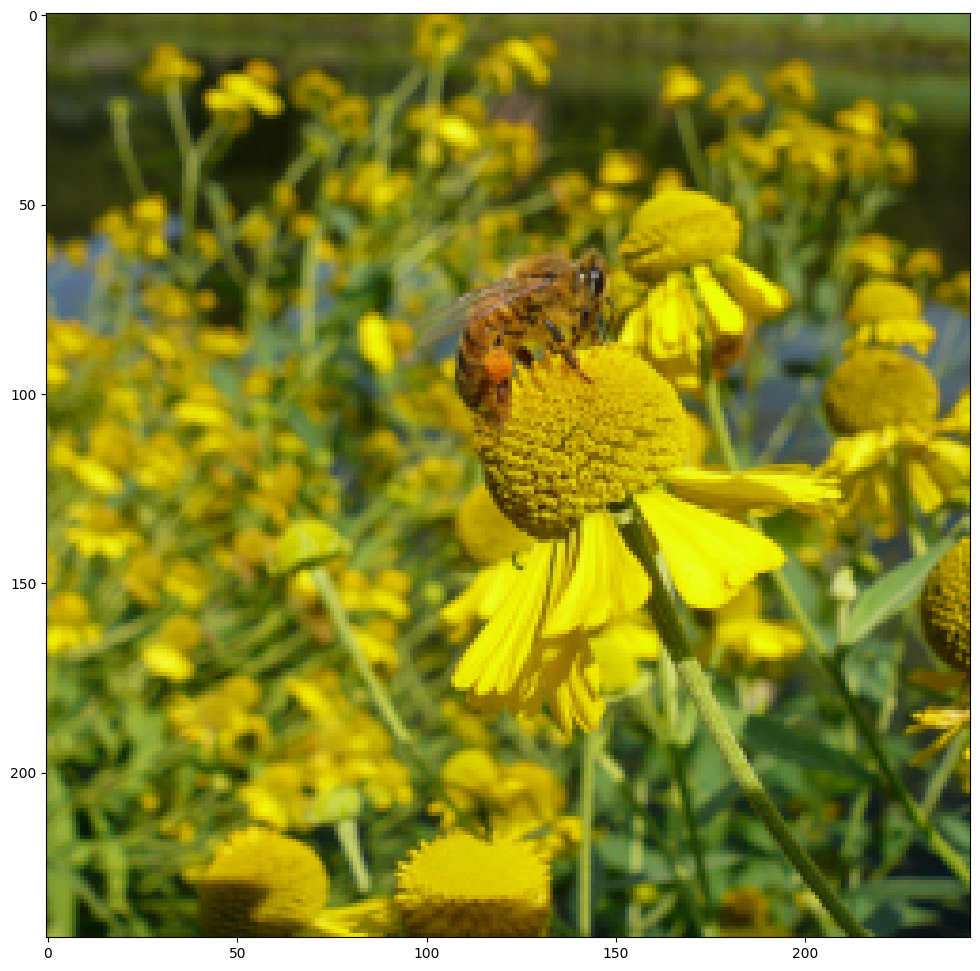

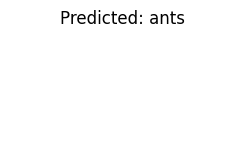

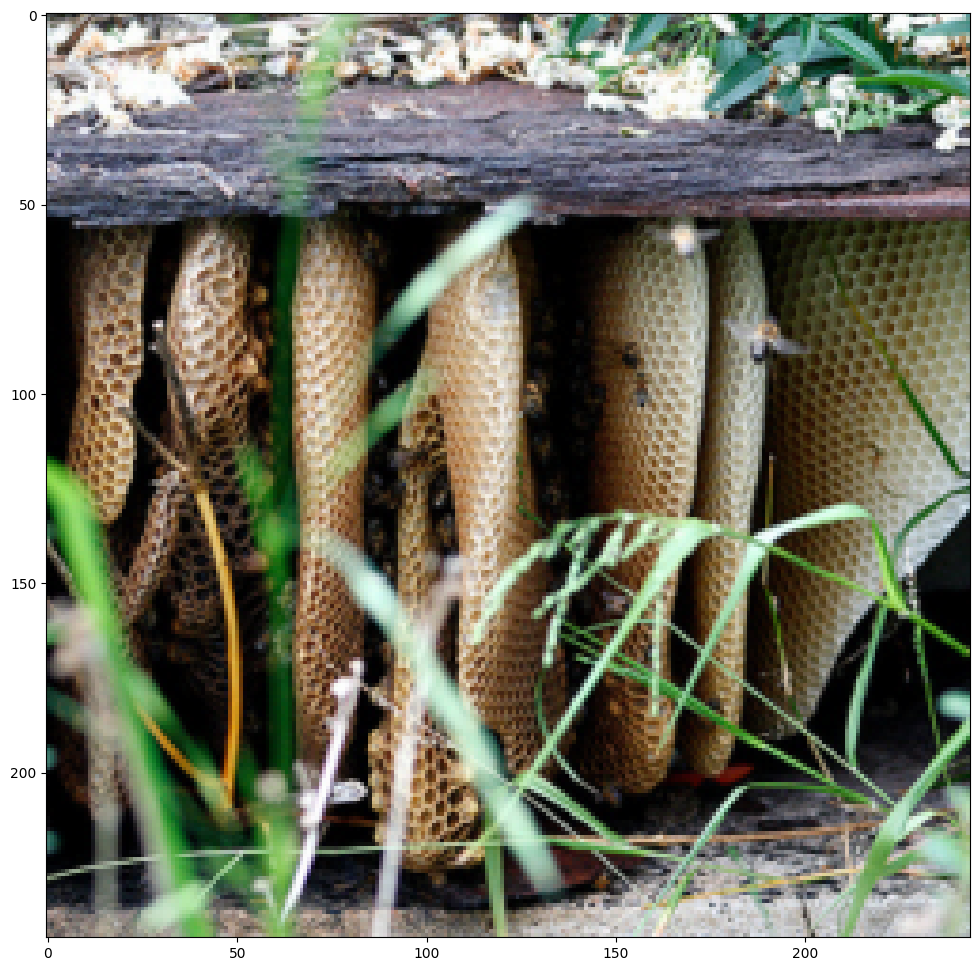

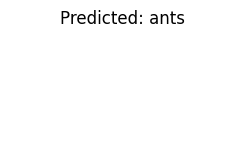

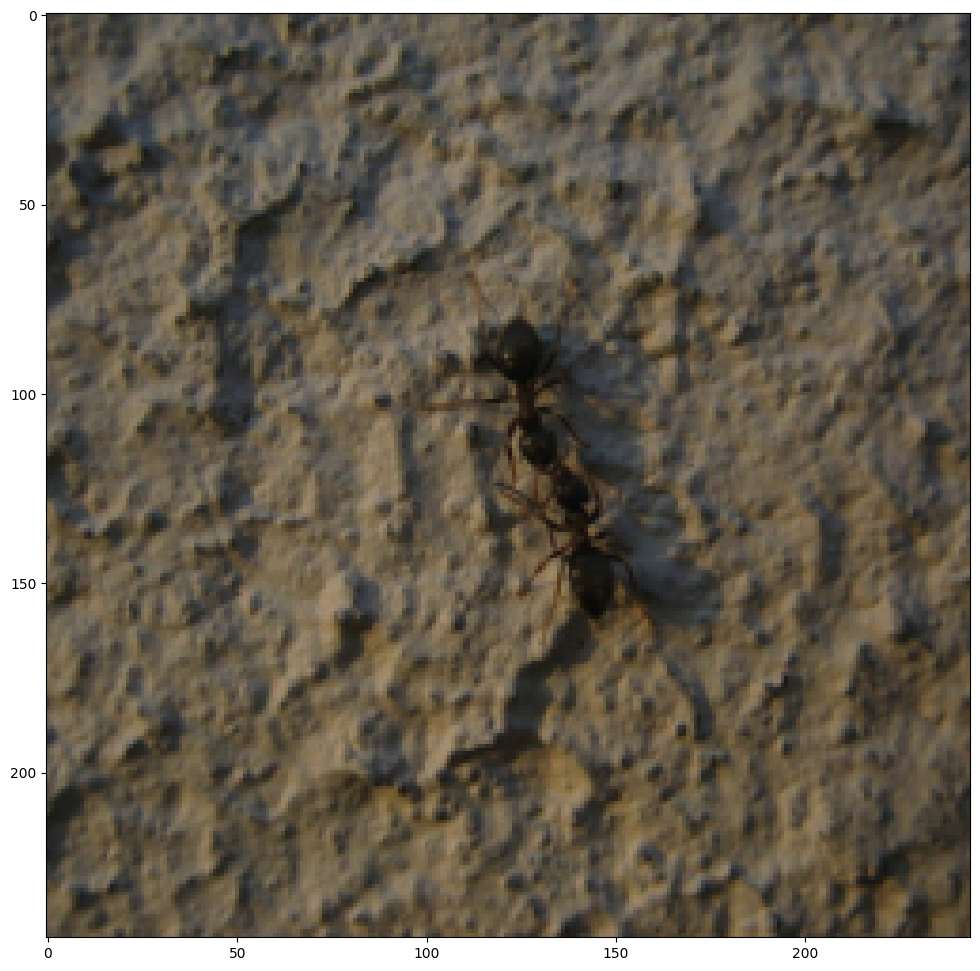

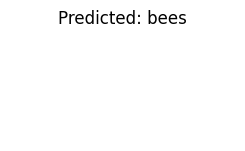

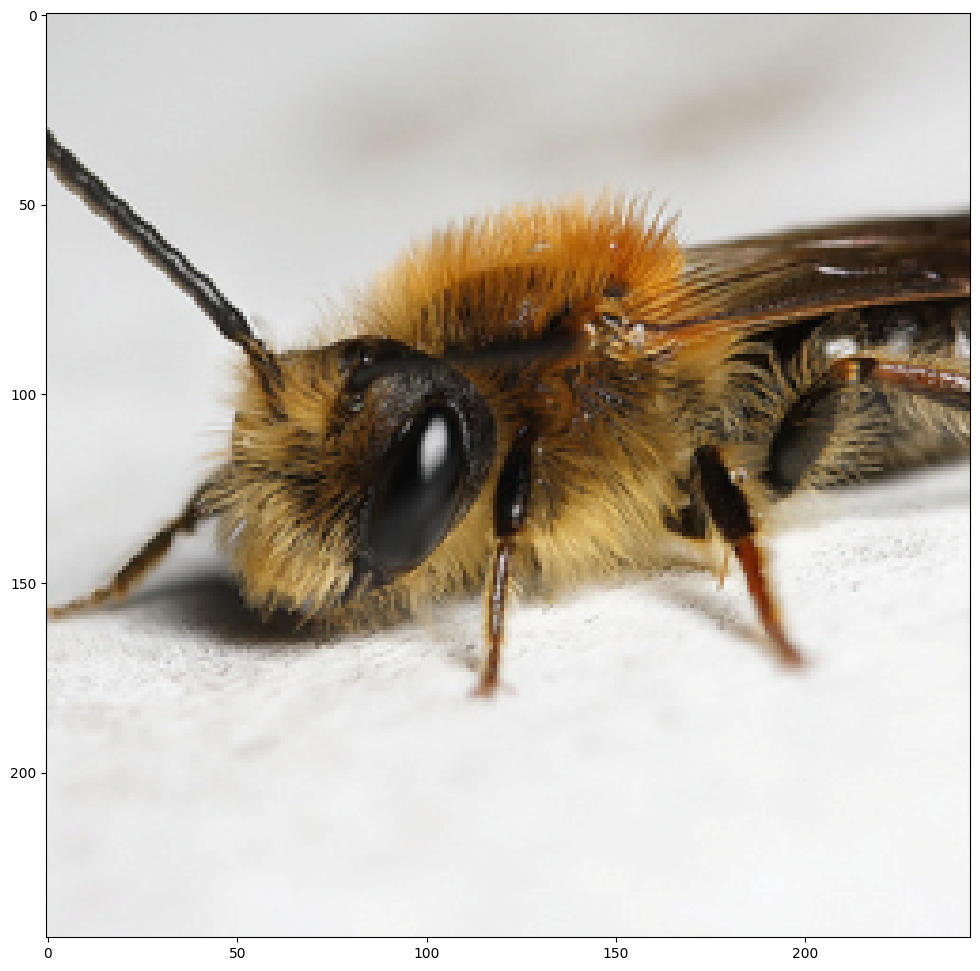

In [55]:
visualize_model(alexnet_retrained)

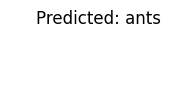

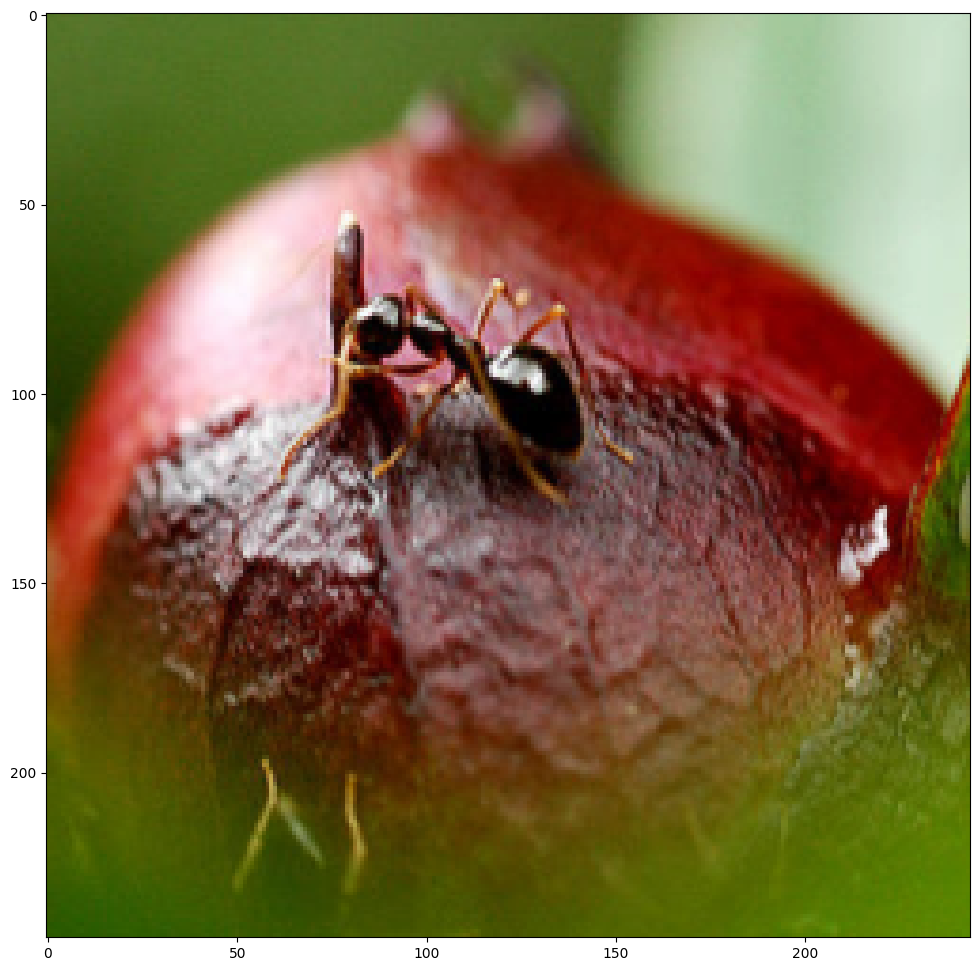

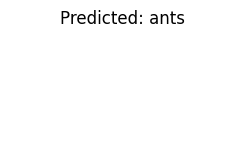

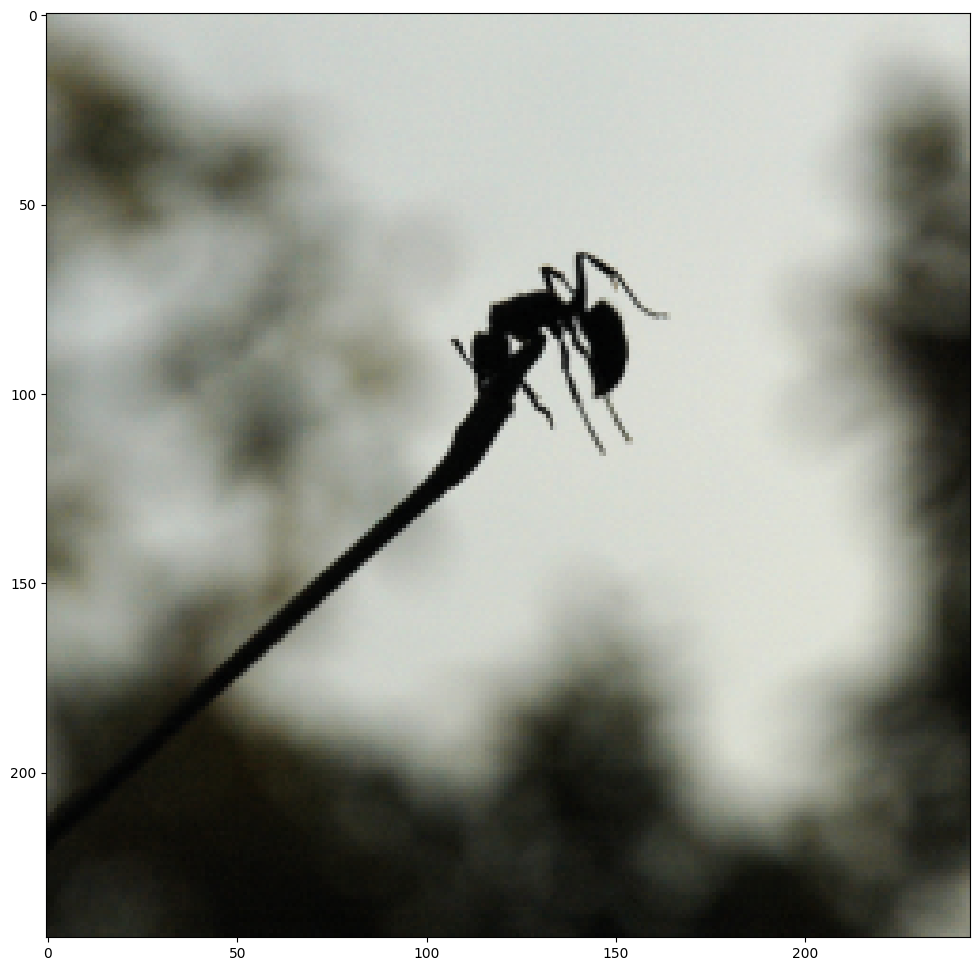

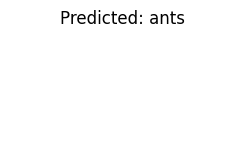

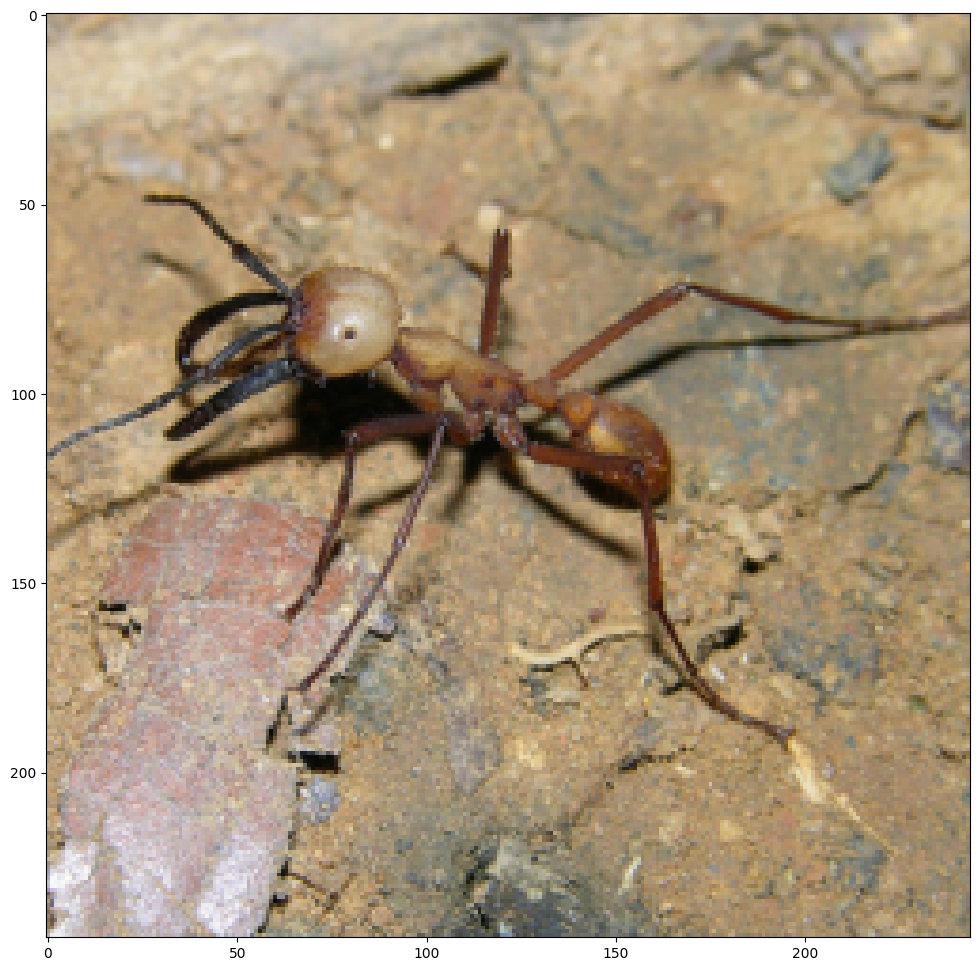

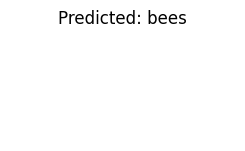

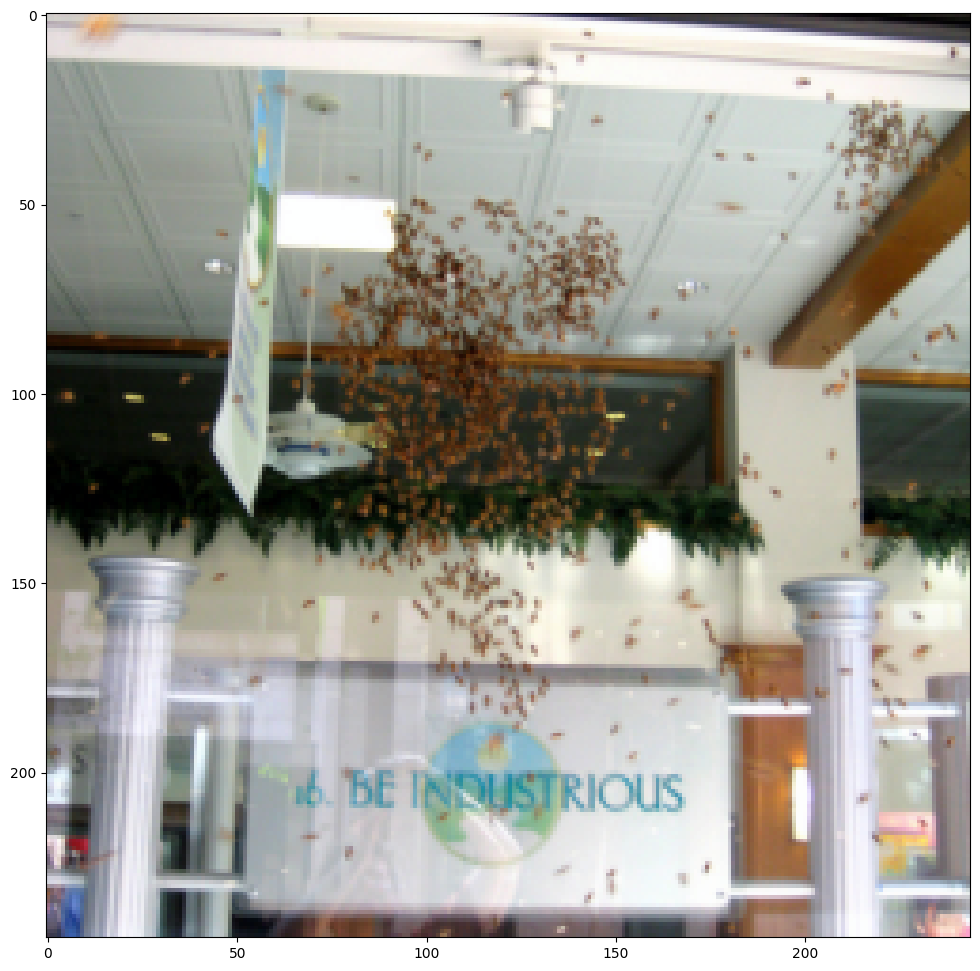

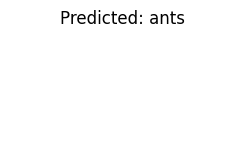

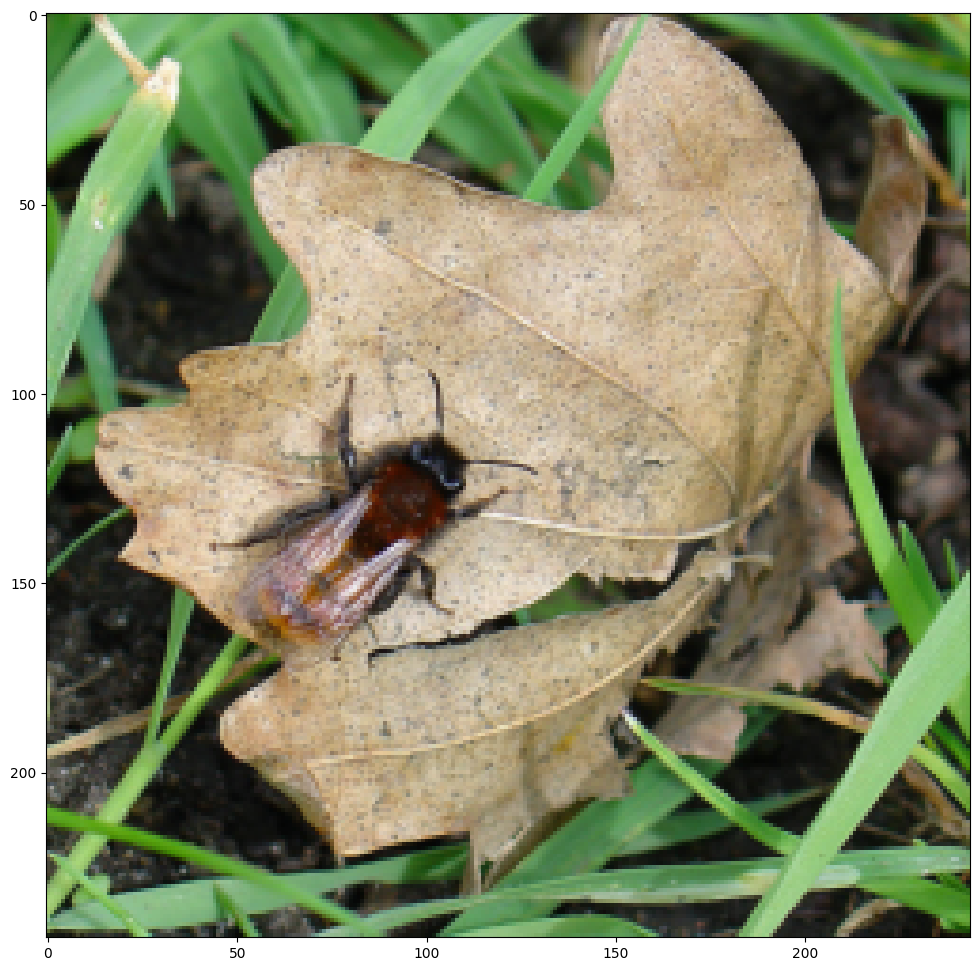

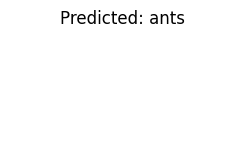

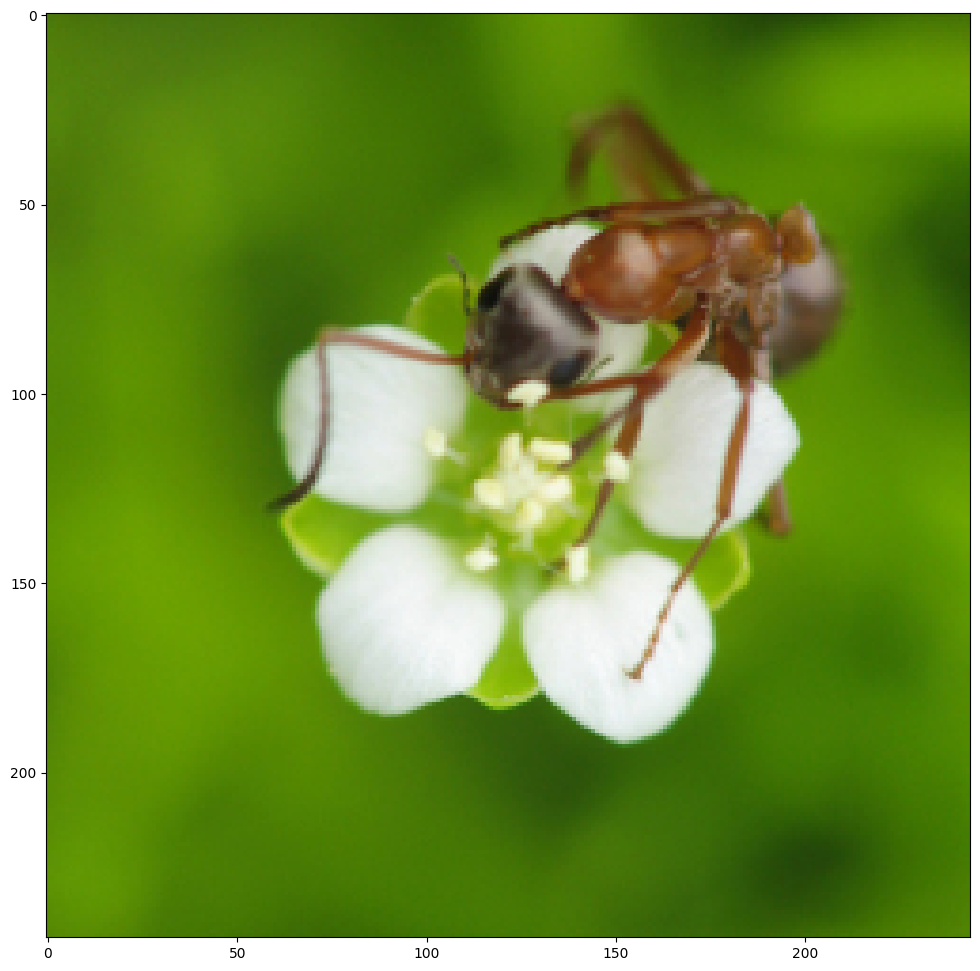

In [56]:
visualize_model(vggnet_retrained)